In [ ]:
!pip install transformers
!git clone https://github.com/CAMeL-Lab/CAMeLBERT.git
!pip install torch
import transformers
from transformers import AutoTokenizer, AutoModel
import torch
import os
import re
import nltk
import pickle
from collections import Counter
import string
import random
from collections import deque
from collections import defaultdict
import pandas as pd
import numpy as np
import csv
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# loading target words into memory
file_path = 'target_words.pkl'

# Open the Pickle file and load the data
with open(file_path, 'rb') as file:
    target_words = pickle.load(file)

# Function to load occurrences from a file and return as a list of strings
def load_occurrences_file(file_path):
    with open(file_path, 'r') as infile:
        occurrences_list = [line.strip() for line in infile]

    return occurrences_list

# Load occurrences from corpus1_occurrences.txt and corpus2_occurrences.txt
corpus1_occurrences_file = 'corpus1_occurrences.txt'
corpus2_occurrences_file = 'corpus2_occurrences.txt'

corpus1_occurrences = load_occurrences_file(corpus1_occurrences_file)
corpus2_occurrences = load_occurrences_file(corpus2_occurrences_file)

In [ ]:
corpus1_data = {}  # Initialize an empty dictionary

with open('corpus1_occurrences.txt', 'r', encoding='utf-8') as file:
    current_word = None
    sentences = []

    for line in file:
        line = line.strip()

        if line.startswith("Occurrences for "):
            if current_word:
                corpus1_data[current_word] = sentences

            # Extract the target word from the line
            current_word = line[len("Occurrences for '"): -2]
            sentences = []
        elif line:
            sentences.append(line)

if current_word:
    corpus1_data[current_word] = sentences

In [ ]:
corpus2_data = {}  # Initialize an empty dictionary

with open('corpus2_occurrences.txt', 'r', encoding='utf-8') as file:
    current_word = None
    sentences = []

    for line in file:
        line = line.strip()

        if line.startswith("Occurrences for "):
            if current_word:
                corpus2_data[current_word] = sentences

            # Extract the target word from the line
            current_word = line[len("Occurrences for '"): -2]
            sentences = []
        elif line:
            sentences.append(line)

if current_word:
    corpus2_data[current_word] = sentences

In [ ]:
# initialising the model (CAMeLBERT - CA) + tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-ca"

model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = model.to(device)

In [ ]:
model.eval()
embedding_word1_dict = {}  # Dictionary to store embeddings for each word

# Process each target word and its sentences
for word1, sentences in corpus1_data.items():
    embedding_word1_list = []  # List to store embeddings for the current word

    for sentence in sentences:
        # Tokenize the sentence and 'word1', and get token IDs and attention masks
        encoded_dict_sentence1 = tokenizer.encode_plus(
            sentence,
            word1,
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Skip sentences longer than 512 tokens
        if encoded_dict_sentence1['input_ids'].size(1) > 512:
            continue

        # Moving input tensors to GPU
        encoded_dict_sentence1 = {key: value.to('cuda') for key, value in encoded_dict_sentence1.items()}

        # Get embeddings from BERT model
        with torch.no_grad():
            outputs_sentence1 = model(**encoded_dict_sentence1)

        # Find the token IDs of the target word in the input sequence
        target_word_token_ids = encoded_dict_sentence1['input_ids'][0]
        target_indices = [i for i, token_id in enumerate(target_word_token_ids) if token_id == tokenizer.convert_tokens_to_ids(word1)]

        # Extract embeddings corresponding to 'target_indices' from 'outputs_sentence1'
        target_word_embeddings = outputs_sentence1.last_hidden_state[:, target_indices, :]

        # Calculate the mean embedding for the target word
        mean_target_embedding = torch.mean(target_word_embeddings, dim=1, keepdim=True)

        # Append the mean embedding to the list
        embedding_word1_list.append(mean_target_embedding)

    # Convert the list of embeddings for the current word1 to a tensor
    embedding_word1_batched = torch.cat(embedding_word1_list, dim=0)

    # Store the embeddings tensor in the dictionary
    embedding_word1_dict[word1] = embedding_word1_batched

# Checking the number of target words
num_target_words = len(embedding_word1_dict)
print("Number of target words:", num_target_words)

Number of target words: 307


In [ ]:
model.eval()
embedding_word2_dict = {}  # Dictionary to store embeddings for each word

# Process each target word and its sentences
for word2, sentences in corpus2_data.items():
    embedding_word2_list = []  # List to store embeddings for the current word

    for sentence in sentences:
        # Tokenize the sentence and 'word2', and get token IDs and attention masks
        encoded_dict_sentence2 = tokenizer.encode_plus(
            sentence,
            word2,
            add_special_tokens=True,
            max_length=256,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Skip sentences longer than 512 tokens
        if encoded_dict_sentence2['input_ids'].size(1) > 512:
            continue

        # Moving input tensors to GPU
        encoded_dict_sentence2 = {key: value.to('cuda') for key, value in encoded_dict_sentence2.items()}

        # Get embeddings from BERT model
        with torch.no_grad():
            outputs_sentence2 = model(**encoded_dict_sentence2)

        # Find the token IDs of the target word in the input sequence
        target_word_token_ids = encoded_dict_sentence2['input_ids'][0]
        target_indices = [i for i, token_id in enumerate(target_word_token_ids) if token_id == tokenizer.convert_tokens_to_ids(word2)]

        # Extract embeddings corresponding to 'target_indices' from 'outputs_sentence2'
        target_word_embeddings = outputs_sentence2.last_hidden_state[:, target_indices, :]

        # Calculate the mean embedding for the target word
        mean_target_embedding = torch.mean(target_word_embeddings, dim=1, keepdim=True)

        # Append the mean embedding to the list
        embedding_word2_list.append(mean_target_embedding)

    # Convert the list of embeddings for the current word2 to a tensor
    embedding_word2_batched = torch.cat(embedding_word2_list, dim=0)

    # Store the embeddings tensor in the dictionary
    embedding_word2_dict[word2] = embedding_word2_batched

# Checking the number of target words
num_target_words = len(embedding_word2_dict)
print("Number of target words:", num_target_words)

Number of target words: 307


In [ ]:
cosine_similarity_scores = []
for emb1, emb2 in zip(embedding_word1_batched, embedding_word2_batched):
    similarity_score = torch.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
    cosine_similarity_scores.append(similarity_score.mean().item())  # calculate mean and then use item() to get scalar value

for word, score in zip(target_words, cosine_similarity_scores):
    print("Word '{}': Cosine Similarity Score: {:.4f}".format(word, score))

Word 'خالد': Cosine Similarity Score: 0.2812
Word 'رفع': Cosine Similarity Score: 0.5417
Word 'يعلم': Cosine Similarity Score: 0.3932
Word 'قلب': Cosine Similarity Score: 0.3125
Word 'كفر': Cosine Similarity Score: 0.5599
Word 'نصر': Cosine Similarity Score: 0.3620
Word 'إنسان': Cosine Similarity Score: 0.3464
Word 'عزيز': Cosine Similarity Score: 0.3021
Word 'أراد': Cosine Similarity Score: 0.4688
Word 'أيام': Cosine Similarity Score: 0.2448
Word 'دليل': Cosine Similarity Score: 0.4792
Word 'طلب': Cosine Similarity Score: 0.5339
Word 'أخرى': Cosine Similarity Score: 0.2604
Word 'إيمان': Cosine Similarity Score: 0.3880
Word 'شعر': Cosine Similarity Score: 0.4297
Word 'نسخ': Cosine Similarity Score: 0.3385
Word 'بغداد': Cosine Similarity Score: 0.2760
Word 'مسجد': Cosine Similarity Score: 0.2604
Word 'ربيع': Cosine Similarity Score: 0.5885
Word 'يجب': Cosine Similarity Score: 0.4036
Word 'حرم': Cosine Similarity Score: 0.3359
Word 'سفيان': Cosine Similarity Score: 0.3958
Word 'علماء': C

In [ ]:
import csv
from google.colab import files

# Create and write the data to a CSV file
csv_filename = "cosine_CAMeLBERT_CA.csv"
with open(csv_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Target Word', 'Cosine Similarity Score'])
    for word, score in zip(target_words, cosine_similarity_scores):
        writer.writerow([word, score])

# Download the CSV file using the files module
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

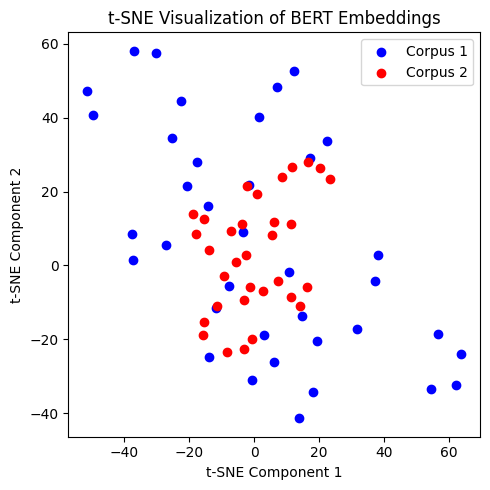

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Step 1: Choosing target word to display
chosen_target_word = "الله"

# Step 2: Find the index of the chosen_target_word in the list of target_words
target_word_index = target_words.index(chosen_target_word)

# Step 3: Retrieve the corresponding embeddings for chosen_target_word
chosen_target_embeddings_corpus1 = target_word_embeddings1[target_word_index]
chosen_target_embeddings_corpus2 = target_word_embeddings2[target_word_index]

# Reduce the dimensionality using t-SNE separately for each set of embeddings
tsne_corpus1 = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_corpus2 = TSNE(n_components=2, random_state=42, perplexity=10)

reduced_embeddings_corpus1 = tsne_corpus1.fit_transform(chosen_target_embeddings_corpus1)
reduced_embeddings_corpus2 = tsne_corpus2.fit_transform(chosen_target_embeddings_corpus2)

# Plot the t-SNE visualization with different colors for component 1 and component 2
plt.figure(figsize=(5, 5))
plt.scatter(reduced_embeddings_corpus1[:, 0], reduced_embeddings_corpus1[:, 1], color='blue', label='Corpus 1')
plt.scatter(reduced_embeddings_corpus2[:, 0], reduced_embeddings_corpus2[:, 1], color='red', label='Corpus 2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of BERT Embeddings')
plt.legend()
plt.tight_layout()
plt.show()